# Detección de fraude transaccional usando ingeniería de características automática

![ft](https://www.featuretools.com/wp-content/uploads/2017/12/FeatureLabs-Logo-Tangerine-800.png)

Demo realizado para:

![SoftPoint](https://softpoint.es/wp-content/uploads/2016/05/cropped-logo-1-1.png)

por

![Alephsoft](https://alephsoftai.com/wp-content/uploads/2021/03/Logo-v1.png)


Para este demo utilizaremos un dataset de transacciones con tarjeta de crédito simuladas, conteniendo transacciones legítimas y fraudulentas, desde el 1 de Enero de 2019 al 31 de Dicembre de 2020. Se tienen tarjetas de crédito de 1000 clientes, con transacciones en 800 negocios.

Los datos originales están en [este enlace](https://www.kaggle.com/kartik2112/fraud-detection)

In [1]:
# Importamos librerías
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from matplotlib import pyplot as plt
from sklearn.svm import SVC
import featuretools as ft
import composeml as cp
import pandas as pd
import numpy as np
import datetime
import utils
import glob
import os

## 1. Lectura de datos

Trabajaremos sobre los datos `customersTrain.csv` y `transactionsTrain.csv`.

**customers:**

Contiene datos de clientes en general. Los nombres de los campos son auto descriptivos.

- cc_num: identificador único de cliente
- dob: fecha de nacimiento

In [2]:
customers = pd.read_csv("data/customersTrain.csv", low_memory=False)

In [3]:
customers.head()

,cc_num,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob
0,60416207185,Mary,Diaz,F,9886 Anita Drive,Fort Washakie,WY,82514,43.0048,-108.8964,1645,Information systems manager,1986-02-17
1,60422928733,Jeffrey,Powers,M,38352 Parrish Road Apt. 652,North Augusta,SC,29860,33.6028,-81.9748,46944,Secondary school teacher,1942-04-02
2,60423098130,Jason,Gray,M,875 Amy Point,Amorita,OK,73719,36.9412,-98.2458,83,Barrister's clerk,1958-07-28
3,60427851591,Bradley,Martinez,M,3426 David Divide Suite 717,Burns Flat,OK,73624,35.3492,-99.1880,2142,Politician's assistant,1976-06-30
4,60487002085,David,White,M,66234 Hall Lock Suite 758,Jackson,MS,39211,32.3739,-90.1293,233060,"Horticulturist, commercial",1972-08-15


**transactions:**

Contiene los datos de las transacciones, el comercio, y la etiqueta de si fue fraude o no.

In [4]:
transactions = pd.read_csv("data/transactionsTrain.csv", low_memory=False)

In [5]:
transactions.head()

,trans_date_trans_time,cc_num,merchant,category,amt,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


___
**Nota 1:**

La aplicación de detección de fraude representa un reto en el sentido de que las clases positivas y negativas están completamente desbalanceadas. En este caso, el número total de transacciones es:

In [6]:
len(transactions)

1296675

Mientras que, el número de transacciones fraudulentas es:

In [7]:
transactions['is_fraud'].sum()

7506

Esto es, el porcentaje de transacciones fraudulentas es aproximadamente del 0.5%.

En este caso, como el objetivo es demostrar el uso de featuretools, obtendremos un muestreo de las transacciones para las cuales el número de transacciones fraudulentas y no fraudulentas sean comparables:

In [8]:
transactions_fraud = transactions[transactions['is_fraud'] == 1].copy()
transactions_no_fraud_sample = transactions[transactions['is_fraud'] == 0].sample(10000).copy()

In [9]:
transactions_train = pd.concat([transactions_fraud, transactions_no_fraud_sample], 
                               axis=0).sample(frac=1).reset_index(drop=True)

In [10]:
transactions_train

,trans_date_trans_time,cc_num,merchant,category,amt,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2019-01-09 01:26:27,6526955903501879,fraud_Koepp-Witting,grocery_pos,337.06,8276e627c4a4b500a02ad2e7bd5ebf7c,1326072387,26.137097,-82.463519,1
1,2019-01-17 23:25:29,372246459334925,fraud_Kuphal-Bartoletti,misc_net,907.81,ca97c21591f0055cd0018f981de76197,1326842729,44.262365,-103.713426,1
2,2019-02-25 19:40:21,30518206766474,fraud_Kris-Padberg,shopping_pos,8.13,7d076ca607f51e0e52fa3fd9affefe1b,1330198821,36.327785,-89.343424,0
3,2019-02-04 21:37:10,4451952084362894,fraud_Botsford Ltd,shopping_pos,860.18,fb7e5f0b85f08a80261901fb44b595f0,1328391430,33.671772,-101.583712,1
4,2019-10-02 00:15:00,6526777409109795,fraud_Bradtke PLC,grocery_pos,332.44,be5483ec00f4e3f99838283e7cc7f3f6,1349136900,41.552746,-74.233896,1
...,...,...,...,...,...,...,...,...,...,...
17501,2019-11-16 11:06:11,3542162746848552,fraud_Harris Inc,gas_transport,20.48,e7cb8274c36ed911901e6096a929f80a,1353063971,43.095851,-94.159529,1
17502,2019-11-18 14:03:55,370818583810103,fraud_Jast Ltd,shopping_net,6.02,c7dd0e7caf10152a1c0b8530c250d965,1353247435,39.030899,-79.805584,0
17503,2019-04-17 08:20:55,30199621383748,"fraud_Harris, Gusikowski and Heaney",grocery_net,51.18,47d9ea3f0a047203e19a96e3a2b0e44c,1334650855,34.224368,-96.711636,0
17504,2019-02-25 19:00:50,30197398657930,fraud_Emmerich-Rau,personal_care,44.54,aafbf4eac1e926e38351eb3a1f393ef1,1330196450,35.694605,-77.777662,0


Así mismo, obtendremos los clientes relativos a este subconjunto de transacciones obtenido:

In [11]:
customers_train = customers[customers['cc_num'].isin(transactions_train['cc_num'])]

In [12]:
customers_train

,cc_num,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob
0,60416207185,Mary,Diaz,F,9886 Anita Drive,Fort Washakie,WY,82514,43.0048,-108.8964,1645,Information systems manager,1986-02-17
1,60422928733,Jeffrey,Powers,M,38352 Parrish Road Apt. 652,North Augusta,SC,29860,33.6028,-81.9748,46944,Secondary school teacher,1942-04-02
2,60423098130,Jason,Gray,M,875 Amy Point,Amorita,OK,73719,36.9412,-98.2458,83,Barrister's clerk,1958-07-28
3,60427851591,Bradley,Martinez,M,3426 David Divide Suite 717,Burns Flat,OK,73624,35.3492,-99.1880,2142,Politician's assistant,1976-06-30
4,60487002085,David,White,M,66234 Hall Lock Suite 758,Jackson,MS,39211,32.3739,-90.1293,233060,"Horticulturist, commercial",1972-08-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...
978,4958589671582726883,Aaron,Pena,M,793 Hooper Tunnel Suite 154,Burke,VA,22015,38.7894,-77.2818,43102,Health visitor,1950-11-27
979,4973530368125489546,Mary,Rodriguez,F,8986 Fitzgerald Plains,Winslow,AR,72959,35.8312,-94.1187,2786,Musician,1965-09-27
980,4980323467523543940,Patrick,Massey,M,7812 Shane Shoals Apt. 607,North Haverhill,NH,3774,44.0978,-72.0191,1966,Structural engineer,1947-10-27
981,4989847570577635369,Vanessa,Anderson,F,21178 Brittney Locks,Prosperity,SC,29127,34.1832,-81.5324,8333,Archaeologist,1994-07-09


**Nota 2:**

Para la tarea de predecir transacciones fraudulentas, ciertos datos sensibles (nombre, domicilio exacto) no son necesarios. Por otro parte los datos de ciudad no son requeridos dado que se tiene información de código postal y coordenadas:

In [13]:
customers_train.drop(columns=['first', 'last', 'street', 'city', 'city_pop'], inplace=True)

Adicionalmente, `featuretools` entiende las variables de latitud y longitud en una tupla:

In [14]:
customers_train['latlong'] = customers_train[['lat', 'long']].apply(tuple, axis=1)
customers_train.drop(columns=['lat', 'long'], inplace=True)

In [15]:
transactions_train['merch_latlong'] = transactions_train[['merch_lat', 'merch_long']].apply(tuple, axis=1)
transactions_train.drop(columns=['merch_lat', 'merch_long'], inplace=True)

___
## 2. Preprocesamiento de datos

Para evitar que featuretools genere características involucrando la variable objetivo de predicción, la separaremos del proceso:

In [16]:
target_train = transactions_train[['trans_num', 'is_fraud']].copy()
transactions_train.drop(columns=['is_fraud'], inplace=True)

1. El primer paso es crear un conjunto de entidades, con sus respectivas relaciones usando la clase `EntitySet` de la libería `featuretools`:
   - Declaración de los tipos de variables para `featuretools`.
   - Añadir las entidades: en este caso `customers` y `transactions`
   - Añadir las relaciones entre las entidades: en este caso, las entidades se relacionan a través de la variable `cc_num`.

In [17]:
def create_entity_set(customers, transactions):
    """
    Esta función genera el conjunto de entidades y relaciones a partir de los datos de clientes (customers) y
    transacciones (transactions).
    :param pd.DataFrame customers: Datos de clientes.
    :param pd.DataFrame transactions: Datos de transacciones.
    :return: Conjunto de entidades.
    """
    # Tipos de variables
    customers_vtypes = {
        "cc_num": ft.variable_types.Id,
        "gender": ft.variable_types.Categorical,
        "state": ft.variable_types.Categorical,
        "zip": ft.variable_types.ZIPCode,
        "latlong": ft.variable_types.LatLong,
        "job": ft.variable_types.Categorical,
        "dob": ft.variable_types.DateOfBirth
    }
    transactions_vtypes = {
        "trans_date_trans_time": ft.variable_types.DatetimeTimeIndex,
        "cc_num": ft.variable_types.Index,
        "merchant": ft.variable_types.Categorical,
        "category": ft.variable_types.Categorical,
        "amt": ft.variable_types.Numeric,
        "trans_num": ft.variable_types.Id,
        "unix_time": ft.variable_types.Numeric,
        "merch_latlong": ft.variable_types.LatLong,
        # "is_fraud": ft.variable_types.Boolean,
    }
    
    # Entity set
    es = ft.EntitySet("fraud")
    es.entity_from_dataframe(entity_id="customers",
                             dataframe=customers,
                             index="cc_num",
                             variable_types=customers_vtypes)

    es.entity_from_dataframe(entity_id="transactions",
                             dataframe=transactions,
                             index="trans_num",
                             variable_types=transactions_vtypes,
                             time_index="trans_date_trans_time")
    
    # Relación entre entidades
    es.add_relationship(ft.Relationship(es["customers"]["cc_num"], es["transactions"]["cc_num"]))
    
    return es

In [18]:
es_train = create_entity_set(customers_train, transactions_train)

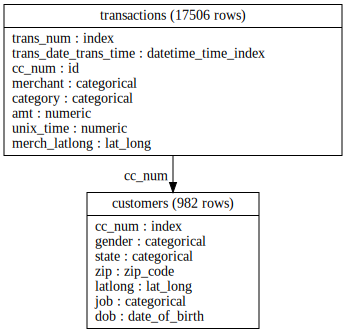

In [19]:
es_train.plot()

2. El segundo paso es construir la matriz de características que alimentará al modelo de predicción.
   - Se usa la funcionalidad `deep feature synthesis` de `featuretools`, especificándole el conjunto de entidades y la entidad objetivo de predicción.
   - Se codifican las variables categóricas.

In [20]:
def feature_synthesis(es, target):
    """
    Esta función entrega la matriz de características usando featuretools.
    :param ft.EntitySet es: Conjunto de entidades.
    :return: pd.DataFrame de matriz de características, y características.
    """
    # Deep feature synthesis
    feature_matrix, features = ft.dfs(target_entity="transactions",
                                      entityset=es,
                                      ignore_variables={"transactions": ["cc_num"]},
                                      verbose=True)
    
    # Codificado
    fm_encoded, features_encoded = ft.encode_features(feature_matrix,
                                                      features)
    
    # Unión con variable objetivo de predicción
    fm_encoded = fm_encoded.reset_index().merge(target, on='trans_num').drop(columns='trans_num')
    
    return fm_encoded, features_encoded

In [21]:
fm_encoded_train, features_encoded_train = feature_synthesis(es_train, target_train)

Built 35 features
Elapsed: 00:01 | Progress: 100%|██████████


In [22]:
fm_encoded_train

,merchant = fraud_Kilback LLC,merchant = fraud_Cormier LLC,merchant = fraud_Kuhn LLC,merchant = fraud_Boyer PLC,merchant = fraud_Doyle Ltd,merchant = fraud_Rau and Sons,merchant = fraud_Bradtke PLC,"merchant = fraud_Lockman, West and Runte",merchant = fraud_Kozey-Boehm,merchant = fraud_Vandervort-Funk,...,customers.YEAR(dob) = 1984,customers.YEAR(dob) = 1986,customers.YEAR(dob) = 1976,customers.YEAR(dob) = 1970,customers.YEAR(dob) = 1993,customers.YEAR(dob) = 1985,customers.YEAR(dob) = 1990,customers.YEAR(dob) is unknown,"HAVERSINE(customers.latlong, merch_latlong)",is_fraud
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,61.854478,0
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,32.474292,0
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,80.210113,0
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,48.755728,0
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,39.799508,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17501,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,48.466135,0
17502,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,True,55.179692,0
17503,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,26.994792,0
17504,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,True,3.509051,0


3. Flujo completo de preprocesamiento para entrenamiento y pruebas.

In [23]:
def complete_pipeline_train_test(customers, transactions):
    """
    Esta función resume el flujo completo de preprocesamiento para el entrenamiento y pruebas.
    :param pd.DataFrame customers: Datos de clientes.
    :param pd.DataFrame transactions: Datos de transacciones.
    :return: Conjunto de entidades, matriz de características codificada.
    """
    customers.drop(columns=['first', 'last', 'street', 'city', 'city_pop'], inplace=True)
    customers['latlong'] = customers[['lat', 'long']].apply(tuple, axis=1)
    customers.drop(columns=['lat', 'long'], inplace=True)
    
    transactions['merch_latlong'] = transactions[['merch_lat', 'merch_long']].apply(tuple, axis=1)
    transactions.drop(columns=['merch_lat', 'merch_long'], inplace=True)
    
    target = transactions[['trans_num', 'is_fraud']].copy()
    transactions.drop(columns=['is_fraud'], inplace=True)
    
    es = create_entity_set(customers, transactions)
    fm_encoded, features_encoded = feature_synthesis(es, target)
    return es, fm_encoded, features_encoded, target

## 3. Selección de características

Para este ejemplo corremos un algoritmo `RandomForestClassifier` para determinar el top-$n$ de variables más importantes para el modelo.

Esto se hace con el fin de descartar aquellas variables que no tienen poder predictivo sobre la variable objetivo.

In [24]:
def feature_importance(fm_encoded, features_encoded, num_features=20):
    """
    Esta función calcula las num_features más importantes de acuerdo al clasificador RandomForestClassifier.
    :param pd.DataFrame fm_encoded: Matriz de características codificada.
    :param list features_encoded: Lista de características codificadas.
    :param int num_features: Número de características top a devolver.
    :return: Lista de características con mayor poder predictivo.
    """
    X = fm_encoded.copy()
    X = X.fillna(0)
    y = X.pop("is_fraud").astype('bool')
    
    clf = RandomForestClassifier(n_estimators=400, n_jobs=-1)
    scores = cross_val_score(estimator=clf,X=X, y=y, cv=3,
                             scoring="f1", verbose=True)
    print(f"F1 {scores.mean()} +/- {scores.std()}")
    
    clf.fit(X, y)
    top_features = utils.feature_importances(clf, features_encoded, n=num_features)
    
    return top_features

In [25]:
top_features = feature_importance(fm_encoded_train, features_encoded_train, num_features=20)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   10.5s finished


F1 0.6618955926799504 +/- 0.09921870950406955
1: Feature: amt, 0.354
2: Feature: customers.MEAN(transactions.amt), 0.044
3: Feature: unix_time, 0.042
4: Feature: customers.STD(transactions.amt), 0.037
5: Feature: customers.MAX(transactions.amt), 0.031
6: Feature: customers.SUM(transactions.amt), 0.029
7: Feature: customers.STD(transactions.unix_time), 0.029
8: Feature: customers.MEAN(transactions.unix_time), 0.024
9: Feature: customers.SKEW(transactions.amt), 0.020
10: Feature: customers.SKEW(transactions.unix_time), 0.020
11: Feature: HAVERSINE(customers.latlong, merch_latlong), 0.018
12: Feature: customers.MAX(transactions.unix_time), 0.017
13: Feature: category = shopping_net, 0.017
14: Feature: customers.MIN(transactions.unix_time), 0.015
15: Feature: customers.MIN(transactions.amt), 0.015
16: Feature: customers.SUM(transactions.unix_time), 0.014
17: Feature: category = gas_transport, 0.012
18: Feature: category is unknown, 0.012
19: Feature: customers.COUNT(transactions), 0.012
20

## 4. Entrenamiento del modelo

Para el entrenamiento y validación del modelo, corremos todo el flujo sobre datos de prueba

In [26]:
customers = pd.read_csv('data/customersTest.csv', low_memory=False)
transactions = pd.read_csv('data/transactionsTest.csv', low_memory=False)

In [27]:
transactions['is_fraud'].sum()

2145

In [28]:
transactions_fraud = transactions[transactions['is_fraud'] == 1].copy()
transactions_no_fraud_sample = transactions[transactions['is_fraud'] == 0].sample(3000).copy()

In [29]:
transactions_test = pd.concat([transactions_fraud, transactions_no_fraud_sample], 
                              axis=0).sample(frac=1).reset_index(drop=True)
customers_test = customers[customers['cc_num'].isin(transactions_test['cc_num'])]

In [30]:
es_test, _, _, target_test = complete_pipeline_train_test(customers_test, transactions_test)

Built 35 features
Elapsed: 00:00 | Progress: 100%|██████████


Con las entidades de entrenamiento y prueba, podemos entrenar diferentes modelos y validarlos para ver cuál tiene mejor comportamiento sobre los datos de prueba:

In [31]:
def test_classifier(top_features, es_train, target_train, es_test, target_test):
    
    fm_train = ft.calculate_feature_matrix(top_features, entityset=es_train, verbose=True)
    fm_encoded_train, features_encoded_train = ft.encode_features(fm_train, top_features)
    fm_encoded_train = fm_encoded_train.reset_index().merge(target_train, on='trans_num').drop(columns='trans_num')
    
    fm_test = ft.calculate_feature_matrix(top_features, entityset=es_test, verbose=True)
    fm_encoded_test, features_encoded_test = ft.encode_features(fm_test, top_features)
    fm_encoded_test = fm_encoded_test.reset_index().merge(target_test, on='trans_num').drop(columns='trans_num')
    
    X_train = fm_encoded_train.copy()
    X_train = X_train.fillna(0)
    y_train = X_train.pop("is_fraud").astype('bool')
    
    X_test = fm_encoded_test.copy()
    X_test = X_test.fillna(0)
    y_test = X_test.pop("is_fraud").astype('bool')
    
    names = ["Nearest Neighbors", 
             # "Linear SVM",
             # "RBF SVM",
             # "Gaussian Process",
             "Decision Tree", 
             "Random Forest",
             "Neural Net",
             "AdaBoost",
             "Naive Bayes",
             "QDA"]
    
    classifiers = [
        KNeighborsClassifier(3),
        # SVC(kernel="linear", C=0.025),
        # SVC(gamma=2, C=1),
        # GaussianProcessClassifier(1.0 * RBF(1.0)),
        DecisionTreeClassifier(max_depth=5),
        RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
        MLPClassifier(alpha=1, max_iter=1000),
        AdaBoostClassifier(),
        GaussianNB(),
        QuadraticDiscriminantAnalysis()]
    
    for name, clf in zip(names, classifiers):
        clf.fit(X_train, y_train)
        score = cross_val_score(estimator=clf, X=X_test, y=y_test, cv=3,
                             scoring="f1", verbose=True)
        print(f"Classifier: {name} F1-Score {score.mean()} +/- {score.std()}")

In [32]:
test_classifier(top_features, es_train, target_train, es_test, target_test)

Elapsed: 00:00 | Progress: 100%|██████████
Elapsed: 00:00 | Progress: 100%|██████████


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Classifier: Nearest Neighbors F1-Score 0.14415151566397377 +/- 0.059885654379972474


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Classifier: Decision Tree F1-Score 0.5018834185269263 +/- 0.3242151166084689


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s finished


Classifier: Random Forest F1-Score 0.6195123402700123 +/- 0.24285050040180153


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.5s finished


Classifier: Neural Net F1-Score 0.5207301427137506 +/- 0.36824028853741114


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Classifier: AdaBoost F1-Score 0.42580218649507057 +/- 0.36875228970101537
Classifier: Naive Bayes F1-Score 0.5652482942821698 +/- 0.2571741166425606
Classifier: QDA F1-Score 0.8616642521239996 +/- 0.04626164098799659


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished


Entrenamos finalmente el mejor modelo:

In [33]:
def train_classifier(top_features, es, target, classifier="Random Forest"):
    """
    Esta función entrena el clasificado de su preferencia usando las top_features identificadas.
    :param list top_features: Lista de características con mayor poder predictivo.
    :param ft.EntitySet es: Conjunto de entidades.
    :param pd.DataFrame target: variable objetivo de predicción.
    :param str classifier: Clasificador a entrenar.
    :return: Modelo entrenado.
    """
    fm = ft.calculate_feature_matrix(top_features, entityset=es, verbose=True)
    fm_encoded, features_encoded = ft.encode_features(fm, top_features)
    fm_encoded = fm_encoded.reset_index().merge(target, on='trans_num').drop(columns='trans_num')
    
    X = fm_encoded.copy()
    X = X.fillna(0)
    y = X.pop("is_fraud").astype('bool')
    
    clf = {"Nearest Neighbors": KNeighborsClassifier(3), 
           "Linear SVM":SVC(kernel="linear", C=0.025),
           "RBF SVM":SVC(gamma=2, C=1),
           "Gaussian Process": GaussianProcessClassifier(1.0 * RBF(1.0)),
           "Decision Tree":DecisionTreeClassifier(max_depth=5),
           "Random Forest":RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
           "Neural Net":MLPClassifier(alpha=1, max_iter=1000),
           "AdaBoost":AdaBoostClassifier(),
           "Naive Bayes": GaussianNB(),
           "QDA":QuadraticDiscriminantAnalysis()}
    
    clf[classifier].fit(X, y)
    
    return  clf[classifier]

In [50]:
model = train_classifier(top_features, es_train, target_train, classifier="QDA")

Elapsed: 00:00 | Progress: 100%|██████████


## 5. Predicción

Como apuntamos anteriormente, para llevar a cabo la tarea de predicción, el preprocesamiento de los datos debe ser exactamente el mismo que se hizo para el entrenamiento. La única diferencia es que no se generan las etiquetas `target`, por obvias razones.

In [51]:
customers = pd.read_csv('data/customersTest.csv', low_memory=False)
transactions = pd.read_csv('data/transactionsTest.csv', low_memory=False)

In [52]:
transactions_fraud = transactions[transactions['is_fraud'] == 1].sample(2).copy()
transactions_no_fraud_sample = transactions[transactions['is_fraud'] == 0].sample(8).copy()

In [53]:
transactions_pred = pd.concat([transactions_fraud, transactions_no_fraud_sample], 
                              axis=0).sample(frac=1).reset_index(drop=True)
customers_pred = customers[customers['cc_num'].isin(transactions_pred['cc_num'])]

In [54]:
customers_pred

,cc_num,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob
33,581508178315,Michael,Vargas,M,933 Martin Rapids,Desdemona,TX,76445,32.2819,-98.5673,407,Clothing/textile technologist,1978-08-08
103,4481131401752,Frank,Foster,M,37910 Ward Lights,Shrewsbury,MA,1545,42.2848,-71.7205,35299,English as a second language teacher,1975-04-30
218,38530489946071,Laura,Johns,F,95835 Garcia Rue,Arcadia,SC,29320,34.9572,-81.9916,530,Animal technologist,1989-05-14
243,180064817343047,Patricia,Gonzalez,F,8973 Mark Drive,Stephensport,KY,40170,37.9048,-86.5240,344,Chartered public finance accountant,1967-03-30
293,340951438290556,Maria,Garcia,F,865 Thomas Village,Orangeburg,NY,10962,41.0442,-73.9609,5950,Records manager,1971-07-02
294,340953839692349,Tyler,Wright,M,615 Clarke Spring Apt. 172,Warren,MI,48088,42.5164,-82.9832,134056,"Doctor, hospital",1980-05-18
449,3512365128314616,Francisco,Kemp,M,9554 Flores Drive,Arnold,MO,63010,38.4305,-90.3870,35439,Land/geomatics surveyor,1985-03-31
600,3599237318576484,Jessica,Smith,F,06808 Ryan Valleys,Dubre,KY,42731,36.8421,-85.5396,341,Insurance risk surveyor,1932-11-19
701,4681601008538160,Tammy,Davis,F,77663 Colleen Freeway,Moundsville,WV,26041,39.9148,-80.7310,16183,Physiotherapist,1977-08-12
796,6011693194885790,Victoria,Fleming,F,2807 Parker Station Suite 080,Stanchfield,MN,55080,45.6675,-93.2433,2607,"Lecturer, further education",1995-12-04


In [55]:
transactions_pred

,trans_date_trans_time,cc_num,merchant,category,amt,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2020-10-22 20:34:29,4481131401752,"fraud_Schneider, Hayes and Nikolaus",food_dining,140.77,657edf65f358e78f01a5f071cdb374e7,1382474069,42.194614,-71.983068,1
1,2020-08-13 18:09:14,3512365128314616,"fraud_Goyette, Howell and Collier",shopping_pos,9.41,980eb0563060ba656a93ea14400e1246,1376417354,38.048289,-90.770726,0
2,2020-08-17 21:28:24,6011693194885790,fraud_Miller-Harris,misc_net,6.04,5eec40d31c70aa682fd84d4dd0225e0b,1376774904,45.218180,-92.982725,0
3,2020-11-17 00:12:08,3599237318576484,fraud_Volkman-Predovic,shopping_net,5.46,83114bb1bd1aeca174639d229e60ea57,1384647128,37.435511,-84.848289,0
4,2020-12-16 20:08:11,4681601008538160,fraud_Brown-Greenholt,entertainment,119.61,7ef89b62545927a66eeb4a94d9530ec9,1387224491,40.733176,-80.096664,0
5,2020-07-14 18:35:37,340951438290556,fraud_Bednar PLC,kids_pets,49.29,ad1e4d08a4733b8eb9562d69344a42e1,1373826937,41.109331,-73.983656,0
6,2020-10-05 23:54:47,581508178315,fraud_Gleason-Macejkovic,shopping_net,813.57,4a19e852610dee266cb42a282ee235b9,1381017287,32.245776,-97.625541,1
7,2020-07-31 21:14:08,340953839692349,fraud_McGlynn-Jaskolski,misc_pos,1.39,07e8ca32b3f0ade8cffcd56aa12c90d4,1375305248,43.074403,-82.858575,0
8,2020-08-25 13:28:23,180064817343047,fraud_Kihn-Schuster,food_dining,16.59,cc4d005365bd50da891fc19bde2d57b7,1377437303,37.903822,-85.525840,0
9,2020-10-24 16:00:12,38530489946071,fraud_Boyer PLC,misc_pos,9.95,6147c7eea915cc7f707f57cf9d039aa6,1382630412,34.629424,-81.836898,0


In [56]:
def complete_pipeline_predict(customers, transactions, top_features):
    """
    Esta función resume el flujo completo de preprocesamiento para predicción.
    :param pd.DataFrame customers: Datos de clientes.
    :param pd.DataFrame transactions: Datos de transacciones.
    :return: Conjunto de entidades, matriz de características codificada.
    """
    customers.drop(columns=['first', 'last', 'street', 'city', 'city_pop'], inplace=True)
    customers['latlong'] = customers[['lat', 'long']].apply(tuple, axis=1)
    customers.drop(columns=['lat', 'long'], inplace=True)
    
    transactions['merch_latlong'] = transactions[['merch_lat', 'merch_long']].apply(tuple, axis=1)
    transactions.drop(columns=['merch_lat', 'merch_long'], inplace=True)
    
    target = transactions[['trans_num', 'is_fraud']].copy()
    transactions.drop(columns=['is_fraud'], inplace=True)
    
    es = create_entity_set(customers, transactions)
    fm = ft.calculate_feature_matrix(top_features, entityset=es, verbose=True)
    fm_encoded, features_encoded = ft.encode_features(fm, top_features)
    return es, fm_encoded, features_encoded

In [57]:
es_pred, fm_encoded_pred, features_encoded = complete_pipeline_predict(customers_pred,
                                                                       transactions_pred,
                                                                       top_features)

Elapsed: 00:00 | Progress: 100%|██████████


In [58]:
fm_encoded_pred

,amt,customers.MEAN(transactions.amt),unix_time,customers.STD(transactions.amt),customers.MAX(transactions.amt),customers.SUM(transactions.amt),customers.STD(transactions.unix_time),customers.MEAN(transactions.unix_time),customers.SKEW(transactions.amt),customers.SKEW(transactions.unix_time),"HAVERSINE(customers.latlong, merch_latlong)",customers.MAX(transactions.unix_time),category = shopping_net,customers.MIN(transactions.unix_time),customers.MIN(transactions.amt),customers.SUM(transactions.unix_time),category = gas_transport,category is unknown,customers.COUNT(transactions),category = grocery_pos
trans_num,,,,,,,,,,,,,,,,,,,,
ad1e4d08a4733b8eb9562d69344a42e1,49.29,49.29,1373826937,NaN,49.29,49.29,NaN,1373826937,NaN,NaN,4.653590,1373826937,False,1373826937,49.29,1373826937,False,False,1,False
07e8ca32b3f0ade8cffcd56aa12c90d4,1.39,1.39,1375305248,NaN,1.39,1.39,NaN,1375305248,NaN,NaN,39.068637,1375305248,False,1375305248,1.39,1375305248,False,False,1,False
980eb0563060ba656a93ea14400e1246,9.41,9.41,1376417354,NaN,9.41,9.41,NaN,1376417354,NaN,NaN,33.630854,1376417354,False,1376417354,9.41,1376417354,False,False,1,False
5eec40d31c70aa682fd84d4dd0225e0b,6.04,6.04,1376774904,NaN,6.04,6.04,NaN,1376774904,NaN,NaN,33.516549,1376774904,False,1376774904,6.04,1376774904,False,False,1,False
cc4d005365bd50da891fc19bde2d57b7,16.59,16.59,1377437303,NaN,16.59,16.59,NaN,1377437303,NaN,NaN,54.416794,1377437303,False,1377437303,16.59,1377437303,False,True,1,False
4a19e852610dee266cb42a282ee235b9,813.57,813.57,1381017287,NaN,813.57,813.57,NaN,1381017287,NaN,NaN,55.078974,1381017287,True,1381017287,813.57,1381017287,False,False,1,False
657edf65f358e78f01a5f071cdb374e7,140.77,140.77,1382474069,NaN,140.77,140.77,NaN,1382474069,NaN,NaN,14.806102,1382474069,False,1382474069,140.77,1382474069,False,True,1,False
6147c7eea915cc7f707f57cf9d039aa6,9.95,9.95,1382630412,NaN,9.95,9.95,NaN,1382630412,NaN,NaN,24.288779,1382630412,False,1382630412,9.95,1382630412,False,False,1,False
83114bb1bd1aeca174639d229e60ea57,5.46,5.46,1384647128,NaN,5.46,5.46,NaN,1384647128,NaN,NaN,55.954352,1384647128,True,1384647128,5.46,1384647128,False,False,1,False


In [59]:
def predict(model, fm_encoded_pred):
    fm_encoded_pred = fm_encoded_pred.sort_index()
    predictions = pd.DataFrame(index=fm_encoded_pred.index)
    X_pred = fm_encoded_pred
    X_pred = X_pred.fillna(0)
    predictions['pred'] = model.predict(X_pred)
    return predictions

In [60]:
predictions = predict(model, fm_encoded_pred)
predictions

,pred
trans_num,
07e8ca32b3f0ade8cffcd56aa12c90d4,False
4a19e852610dee266cb42a282ee235b9,True
5eec40d31c70aa682fd84d4dd0225e0b,False
6147c7eea915cc7f707f57cf9d039aa6,True
657edf65f358e78f01a5f071cdb374e7,True
7ef89b62545927a66eeb4a94d9530ec9,True
83114bb1bd1aeca174639d229e60ea57,True
980eb0563060ba656a93ea14400e1246,False
ad1e4d08a4733b8eb9562d69344a42e1,False
